--- Calculating Median Age at First Marriage: Eastern Province ---
Processing Women...
Processing Men...
✅ JSON Saved: eastern_Median_Age_Marriage.json
✅ Graph Saved: Eastern_Median_Age_Marriage.png


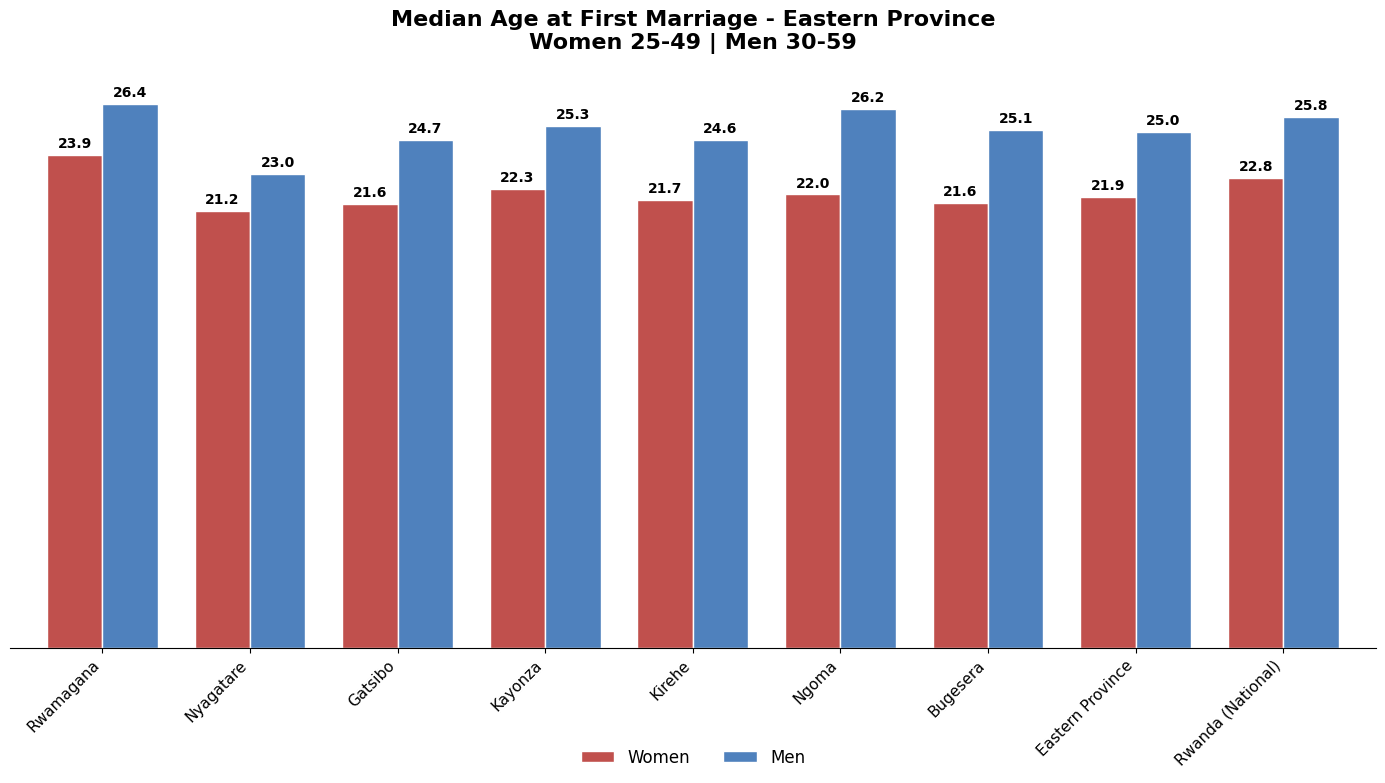

In [1]:
#!/usr/bin/env python3
# dhs_median_age_marriage_eastern.py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

# ------------------------------------------------------------------
# 1. SETTINGS
# ------------------------------------------------------------------
DATA_DIR = "data"
WOMEN_FILE = os.path.join(DATA_DIR, "RWIR81FL.DTA")
MEN_FILE   = os.path.join(DATA_DIR, "RWMR81FL.DTA")

# Eastern Province Districts
DIST_MAP = {
    51: "Rwamagana", 
    52: "Nyagatare", 
    53: "Gatsibo", 
    54: "Kayonza", 
    55: "Kirehe", 
    56: "Ngoma", 
    57: "Bugesera"
}

# Colors: Women (Red), Men (Blue)
COLORS = ["#C0504D", "#4F81BD"]

# ------------------------------------------------------------------
# 2. HELPER: INTERPOLATED MEDIAN (EXACT FLOAT)
# ------------------------------------------------------------------
def get_interpolated_median(df, val_col, wt_col):
    """
    Calculates the 'Interpolated Median' for age at marriage.
    DHS Formula: L + ( (0.5 - P_prev) / P_curr ) * Width
    """
    if df.empty or df[wt_col].sum() == 0:
        return np.nan
    
    data = df[[val_col, wt_col]].dropna()
    freq = data.groupby(val_col)[wt_col].sum().sort_index()
    
    if freq.empty:
        return np.nan

    total_wt = freq.sum()
    props = freq / total_wt
    cum_props = props.cumsum()
    
    try:
        median_bin = cum_props[cum_props >= 0.5].index[0]
    except IndexError:
        return np.nan

    if median_bin == 99: # Never married category
        return np.nan

    idx_loc = cum_props.index.get_loc(median_bin)
    prop_prev = 0.0 if idx_loc == 0 else cum_props.iloc[idx_loc - 1]
    prop_curr = props.loc[median_bin]
    
    # Age bin width is 1
    median_val = median_bin + ( (0.5 - prop_prev) / prop_curr )
    return median_val

# ------------------------------------------------------------------
# 3. ANALYSIS PIPELINE
# ------------------------------------------------------------------
def analyze_marriage():
    print("--- Calculating Median Age at First Marriage: Eastern Province ---")
    
    plot_data = {}
    # Define labels for final display
    locations = list(DIST_MAP.values()) + ["Eastern Province", "Rwanda (National)"]
    for loc in locations:
        plot_data[loc] = {"Women": np.nan, "Men": np.nan}

    # --- PART A: WOMEN (Age 25-49) ---
    if os.path.exists(WOMEN_FILE):
        print("Processing Women...")
        df_w = pd.read_stata(WOMEN_FILE, convert_categoricals=False)
        df_w.columns = df_w.columns.str.lower()
        
        # Filter: Age 25-49
        df_w = df_w[(df_w['v012'] >= 25) & (df_w['v012'] <= 49)].copy()
        df_w['w'] = df_w['v005'] / 1000000.0
        
        # v511: Age at first marriage; v501: Current marital status
        df_w['final_age'] = df_w['v511']
        df_w.loc[df_w['v501'] == 0, 'final_age'] = 99
        
        # National
        plot_data["Rwanda (National)"]["Women"] = get_interpolated_median(df_w, 'final_age', 'w')
        
        # Eastern Province (Region 5)
        df_east_w = df_w[df_w['v024'] == 5]
        plot_data["Eastern Province"]["Women"] = get_interpolated_median(df_east_w, 'final_age', 'w')
        
        # Districts
        for d_code, d_name in DIST_MAP.items():
            subset = df_east_w[df_east_w['sdistrict'] == d_code]
            plot_data[d_name]["Women"] = get_interpolated_median(subset, 'final_age', 'w')
    else:
        print(f"❌ Error: {WOMEN_FILE} not found.")

    # --- PART B: MEN (Age 30-59) ---
    if os.path.exists(MEN_FILE):
        print("Processing Men...")
        df_m = pd.read_stata(MEN_FILE, convert_categoricals=False)
        df_m.columns = df_m.columns.str.lower()
        
        # Filter: Age 30-59 (Standard for Men's Median Age reports)
        df_m = df_m[(df_m['mv012'] >= 30) & (df_m['mv012'] <= 59)].copy()
        df_m['w'] = df_m['mv005'] / 1000000.0
        
        # mv511: Age at first marriage; mv501: Current marital status
        df_m['final_age'] = df_m['mv511']
        df_m.loc[df_m['mv501'] == 0, 'final_age'] = 99
        
        # National
        plot_data["Rwanda (National)"]["Men"] = get_interpolated_median(df_m, 'final_age', 'w')
        
        # Eastern Province (Region 5)
        df_east_m = df_m[df_m['mv024'] == 5]
        plot_data["Eastern Province"]["Men"] = get_interpolated_median(df_east_m, 'final_age', 'w')
        
        # Districts
        for d_code, d_name in DIST_MAP.items():
            subset = df_east_m[df_east_m['smdistrict'] == d_code]
            plot_data[d_name]["Men"] = get_interpolated_median(subset, 'final_age', 'w')
    else:
        print(f"❌ Error: {MEN_FILE} not found.")

    # --- EXPORT TO JSON ---
    df_res = pd.DataFrame.from_dict(plot_data, orient='index')[["Women", "Men"]]
    
    json_filename = "eastern_Median_Age_Marriage.json"
    output_dict = {
        "indicator": "Median age at first marriage (Interpolated)",
        "unit": "Years",
        "population": "Women 25-49, Men 30-59",
        "data": df_res.round(1).to_dict(orient='index')
    }
    
    with open(json_filename, "w") as f:
        json.dump(output_dict, f, indent=4)
    print(f"✅ JSON Saved: {json_filename}")

    # ------------------------------------------------------------------
    # 4. PLOTTING
    # ------------------------------------------------------------------
    ax = df_res.plot(kind="bar", figsize=(14, 8), color=COLORS, width=0.75, edgecolor="white")

    plt.title("Median Age at First Marriage - Eastern Province\nWomen 25-49 | Men 30-59", 
              fontsize=16, fontweight="bold", pad=20)
    
    # Rotated labels for 7+ bars
    plt.xticks(rotation=45, ha='right', fontsize=11)
    plt.grid(axis="y", ls="--", alpha=0.3)
    
    ax.yaxis.set_visible(False)
    for s in ["top", "right", "left"]: ax.spines[s].set_visible(False)

    plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), 
               ncol=2, frameon=False, fontsize=12)

    # Add numeric labels
    for c in ax.containers:
        ax.bar_label(c, fmt='%.1f', padding=3, fontsize=10, fontweight="bold")

    plt.tight_layout()
    plt.savefig("Eastern_Median_Age_Marriage.png", dpi=300)
    print("✅ Graph Saved: Eastern_Median_Age_Marriage.png")

if __name__ == "__main__":
    analyze_marriage()